In [1]:
!pip install torch torchvision matplotlib


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)


In [4]:
train_dataset = FashionMNIST('./data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())

test_dataset = FashionMNIST('./data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())


100%|██████████| 26.4M/26.4M [00:01<00:00, 17.0MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.08MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.79MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Thêm định nghĩa batch_size ở đây
batch_size = 64

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")


Train size: 54000
Validation size: 6000
Test size: 10000


In [7]:
# Custom Gradient Normalization Layer
class GradientNormalization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Forward pass: giữ nguyên input
        ctx.save_for_backward(input)
        return input

    @staticmethod
    def backward(ctx, grad_output):
        # Chuẩn hóa gradient trong backward pass
        mean = torch.mean(grad_output)
        std = torch.std(grad_output)
        grad_input = (grad_output - mean) / (std + 1e-6)  # Tránh chia cho 0
        return grad_input

# Wrapper Module cho GradientNormalization
class GradientNormalizationLayer(nn.Module):
    def __init__(self):
        super(GradientNormalizationLayer, self).__init__()

    def forward(self, x):
        return GradientNormalization.apply(x)


In [9]:
class MLP_with_GradientNorm(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP_with_GradientNorm, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.norm1 = GradientNormalizationLayer()

        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.norm2 = GradientNormalizationLayer()

        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.norm3 = GradientNormalizationLayer()

        self.output = nn.Linear(hidden_dims, output_dims)

        # Khởi tạo trọng số
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)

        x = self.layer1(x)
        x = self.norm1(x)
        x = nn.Sigmoid()(x)

        x = self.layer2(x)
        x = self.norm2(x)
        x = nn.Sigmoid()(x)

        x = self.layer3(x)
        x = self.norm3(x)
        x = nn.Sigmoid()(x)

        out = self.output(x)
        return out


# Khởi tạo các tham số mô hình
input_dims = 784       # Input: 28x28 ảnh => 784 pixel
hidden_dims = 128      # Số node ẩn
output_dims = 10       # 10 nhãn tương ứng với Fashion MNIST
lr = 1e-2              # Learning rate

# Khởi tạo mô hình, hàm mất mát và optimizer
model = MLP_with_GradientNorm(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()  # Hàm mất mát CrossEntropyLoss
optimizer = optim.SGD(model.parameters(), lr=lr)  # Optimizer SGD với learning rate 0.01


In [10]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    # Chế độ huấn luyện
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    # Chế độ đánh giá
    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    # In kết quả sau mỗi epoch
    print(f"EPOCH {epoch + 1}/{epochs}, "
          f"Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")


EPOCH 1/100, Train_Loss: 2.3062, Train_Acc: 0.0997, Validation Loss: 2.3077, Val_Acc: 0.0948
EPOCH 2/100, Train_Loss: 2.3055, Train_Acc: 0.0979, Validation Loss: 2.3040, Val_Acc: 0.0998
EPOCH 3/100, Train_Loss: 2.3056, Train_Acc: 0.1025, Validation Loss: 2.3090, Val_Acc: 0.0950
EPOCH 4/100, Train_Loss: 2.3052, Train_Acc: 0.0978, Validation Loss: 2.3042, Val_Acc: 0.1060
EPOCH 5/100, Train_Loss: 2.3052, Train_Acc: 0.1000, Validation Loss: 2.3049, Val_Acc: 0.0948
EPOCH 6/100, Train_Loss: 2.3054, Train_Acc: 0.0997, Validation Loss: 2.3038, Val_Acc: 0.1060
EPOCH 7/100, Train_Loss: 2.3055, Train_Acc: 0.0980, Validation Loss: 2.3047, Val_Acc: 0.0948
EPOCH 8/100, Train_Loss: 2.3058, Train_Acc: 0.0991, Validation Loss: 2.3071, Val_Acc: 0.0977
EPOCH 9/100, Train_Loss: 2.3052, Train_Acc: 0.1005, Validation Loss: 2.3041, Val_Acc: 0.1013
EPOCH 10/100, Train_Loss: 2.3053, Train_Acc: 0.1017, Validation Loss: 2.3067, Val_Acc: 0.1060
EPOCH 11/100, Train_Loss: 2.3054, Train_Acc: 0.1006, Validation Loss:

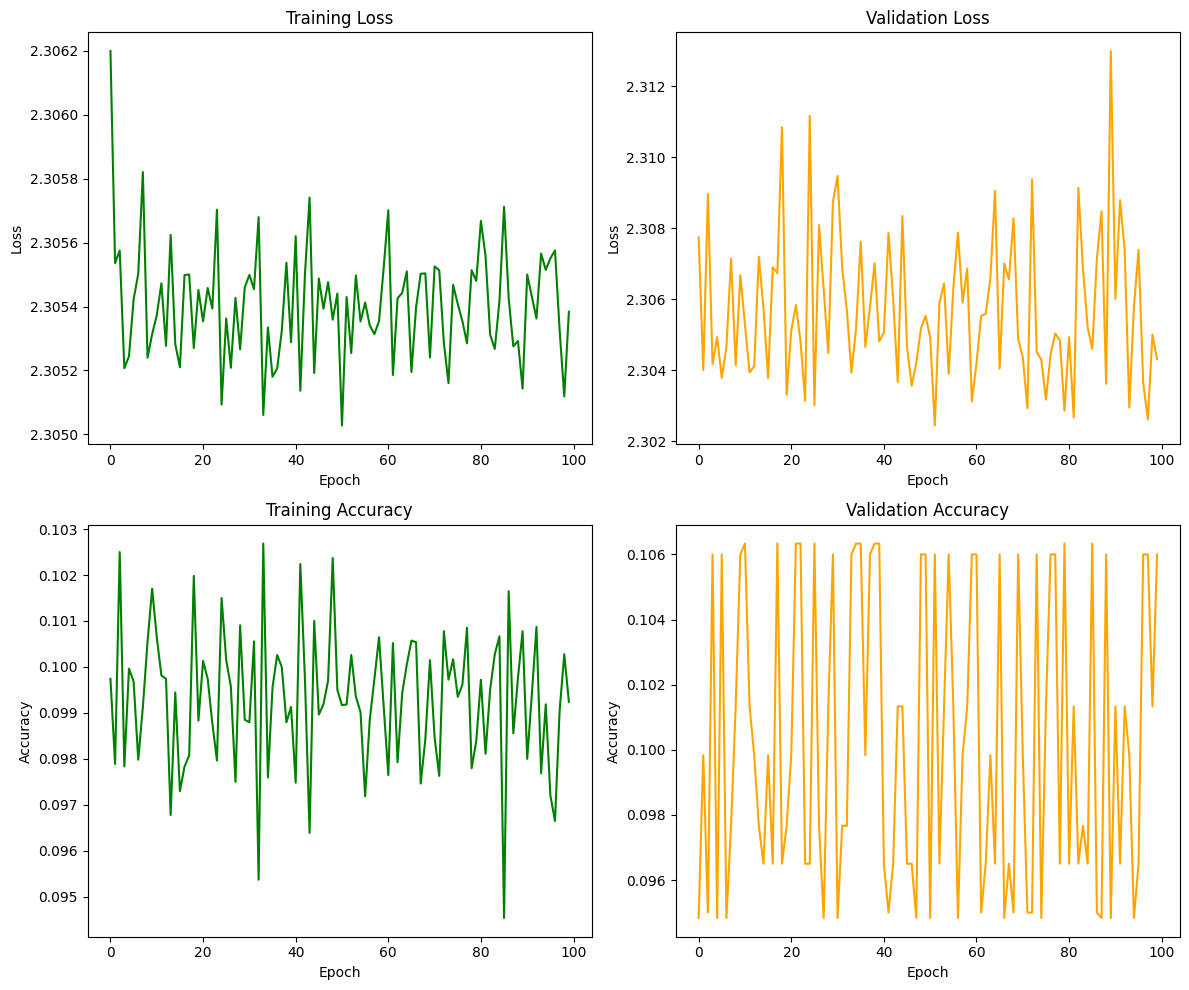

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Vẽ Training Loss
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Vẽ Validation Loss
ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Vẽ Training Accuracy
ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Vẽ Validation Accuracy
ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [12]:
test_target = []
test_predict = []

# Đặt mô hình ở chế độ đánh giá
model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)

        # Lưu lại dự đoán và nhãn thực tế
        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

# Ghép kết quả từ các batch thành một tensor duy nhất
test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)

# Tính toán độ chính xác
test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

# In kết quả
print('Evaluation on test set:')
print(f'Accuracy: {test_acc:.4f}')


Evaluation on test set:
Accuracy: 0.1000
